In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import mne
import csv
from mne.io import read_raw_fif, read_raw_ctf, read_raw_bti, read_raw_kit
from mne.datasets import sample, spm_face, testing
from mne.viz import plot_alignment
from sklearn.svm import SVC  # noqa
from sklearn.cross_validation import ShuffleSplit  # noqa
from mne.decoding import CSP  # noqa
from mne.decoding import TimeDecoding, GeneralizationAcrossTime
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

import time
import h5py
import scipy
import random
from PIL import Image
from scipy import ndimage

/Users/mlion0200/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [72]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import os

import mne
from mne.io import read_raw_ctf
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import Input
from keras.initializers import glorot_uniform
from keras import backend as K
from keras import optimizers
from keras.utils.vis_utils import plot_model
from dnn_utils import *

In [3]:
def load_data(path):
    data_path=path
    data=mne.io.read_raw_ctf(data_path , preload=True)
    sampling_rate = data.info['sfreq']
    return data , sampling_rate

In [4]:
def markers(path, sampling_rate):
    marker = []
    with open(path, 'r') as file: 
        a= file.readline()
        while a != "":
             a= file.readline()
             if any(c in u'+' for c in a):
                     q=a.split()
                     marker.append(int(float(q[1])*sampling_rate))
    return marker

In [5]:
def random_markers(window_size, sampling_rate, marker):
    random_marker = []
    buffer = window_size*sampling_rate
    if len(marker) <= 0:
        return random_marker
    for i in range(len(marker)):
        if i == 0 and marker[0] > buffer:
            random_marker.append(random.randint(buffer,marker[0]))
        elif marker[i-1]+buffer < marker[i]-buffer:
            random_marker.append(random.randint(marker[i-1]+buffer,marker[i]-buffer))
    random_marker.append(random.randint(marker[i]+buffer, 72000-buffer))
    return random_marker

In [6]:
def preprocessing(raw):
    picks = mne.pick_types(raw.info, meg='mag', eeg=False, stim=False, exclude='bads')
    raw.filter(3, 70, picks=picks,l_trans_bandwidth='auto', filter_length='auto', phase='zero', fir_design='firwin')
    channels = ['BG1-2511', 'BG2-2511', 'BG3-2511', 'BP1-2511', 'BP2-2511', 'BP3-2511', 'BQ1-2511', 'BQ2-2511', 'BQ3-2511', 'BR1-2511', 'BR2-2511', 'BR3-2511', 'G12-2511', 'G13-2511', 'G23-2511', 'P12-2511', 'P13-2511', 'Q12-2511', 'Q13-2511', 'Q21-2511', 'Q23-2511', 'R12-2511', 'R13-2511', 'R23-2511', 'SCLK01-177', 'G11-2511', 'G22-2511', 'P11-2511', 'P22-2511', 'Q11-2511', 'Q22-2511', 'R11-2511', 'R22-2511', 'Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2', 'EEG020', 'EEG021', 'EKG']
    raw = raw.drop_channels(channels)
    return raw

In [7]:
def addchannel(raw):
    info = mne.create_info(['STI'], raw.info['sfreq'], ['stim'])
    stim_data = np.zeros((1, len(raw.times)))
    stim_raw = mne.io.RawArray(stim_data, info)
    raw.add_channels([stim_raw], force_update_info=True)
    return raw

In [8]:
# window size (s)
window_size = 0.2

In [76]:
windows=[]
target=[]

ds_name='anonepi_09.ds'
file_path = os.path.join(os.getcwd(), '..', 'data/'+ds_name)
data, sampling_rate=load_data(file_path)
data_preprocessed = preprocessing(data)

# add stimulus channel
data_sti = addchannel(data_preprocessed)
marker_epi = markers(file_path+'/MarkerFile.mrk' , sampling_rate)
marker_non = random_markers(window_size, sampling_rate, marker_epi)
event_1 = marker_epi + marker_non
event_2 = [0] * (len(marker_epi)+len(marker_non))
event_3 = [1] * len(marker_epi) + [2] * len(marker_non)
events = np.array([event_1, event_2, event_3]).T
data_sti.add_events(events, stim_channel='STI')

ds directory : /Users/mlion0200/GitRepo/bcni_epi/notebook/../data/anonepi_09.ds
    res4 data read.
    hc data read.
    Separate EEG position data file not present.
    Quaternion matching (desired vs. transformed):
       0.59   79.40    0.00 mm <->    0.59   79.40    0.00 mm (orig :  -49.13   63.21 -268.88 mm) diff =    0.000 mm
      -0.59  -79.40   -0.00 mm <->   -0.59  -79.40   -0.00 mm (orig :   59.30  -52.80 -268.96 mm) diff =    0.000 mm
     104.68   -0.00    0.00 mm <->  104.68    0.00    0.00 mm (orig :   75.41   71.97 -229.50 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coordinate locations for 3 HPI coils added
Picked positions of 21 EEG channels from channel info
    21 EEG locations added to Polhemus data.
    Measurement info composed.
Finding samples for /Users/mlion0200/GitRepo/bcni_epi/notebook/../data/anonepi_09.ds/anonepi_09.meg4: 
    System clock channel is available, checking which sample

In [77]:
def load_data_events(ds_name):
    file_path = os.path.join(os.getcwd(), '..', 'data/'+ds_name)
    data, sampling_rate=load_data(file_path)
    data_preprocessed = preprocessing(data)

    # add stimulus channel
    # positive = 1, negative = 2
    data_sti = addchannel(data_preprocessed)
    marker_epi = markers(file_path+'/MarkerFile.mrk' , sampling_rate)
    marker_non = random_markers(window_size, sampling_rate, marker_epi)
    event_1 = marker_epi + marker_non
    event_2 = [0] * (len(marker_epi)+len(marker_non))
    event_3 = [1] * len(marker_epi) + [2] * len(marker_non)
    events = np.array([event_1, event_2, event_3]).T
    data_sti.add_events(events, stim_channel='STI')
    return data, data_sti

In [78]:
# Print stimulus channel
find_event_train = mne.find_events(data_sti, stim_channel='STI')
print(find_event_train)

11 events found
Events id: [1 2]
[[  775     0     2]
 [ 4065     0     1]
 [ 6739     0     2]
 [11299     0     1]
 [12443     0     2]
 [12999     0     1]
 [20802     0     2]
 [26818     0     1]
 [29260     0     2]
 [61630     0     1]
 [67654     0     2]]


In [79]:
def compute_epochs_events(data_sti, raw, trial_name):
    events = mne.find_events(data_sti, stim_channel='STI')
    # Events:
    # 9 - non-epi window
    # 8 - epi window
    # picks = mne.pick_types(data.info, meg='grad', eeg=False, stim=False, eog=False, exclude='bads')
    picks = mne.pick_types(raw.info, meg='mag', eeg=False, stim=False, eog=False, exclude='bads')
    event_id = dict(positive=1, negative=2)
    tmin = -0.1  # start of each epoch (500ms before the trigger)
    tmax = 0.1  # end of each epoch (500ms after the trigger)
    epochs = mne.Epochs(data_sti, events, event_id, tmin, tmax, proj=False, picks=picks, baseline=None, preload=True)
    epochs_proj = mne.Epochs(data_sti, events, None, tmin, tmax, proj=True, picks=picks, baseline=None, preload=True)
    labels = epochs.events[:, -1]
    
    # output epochs/labels info
    print(epochs)
    #epochs.plot()
    #epochs.plot_psd(fmin=2., fmax=500)
    print(epochs.get_data().shape)
    # print(epochs.get_data())
    print(labels)

    # evoked without ssp
#     evoked = epochs.average()
#     print(evoked)
#     evoked.plot()

    epochs.save(trial_name+'epochs-epo.fif')
    return epochs, labels

In [80]:
epochs, labels = compute_epochs_events(data_sti, data, 'epoch-09-')

11 events found
Events id: [1 2]
11 matching events found
Loading data for 11 events and 121 original time points ...
0 bad epochs dropped
11 matching events found
0 projection items activated
Loading data for 11 events and 121 original time points ...
0 bad epochs dropped
<Epochs  |  n_events : 11 (all good), tmin : -0.1 (s), tmax : 0.1 (s), baseline : None, ~2.1 MB, data loaded,
 'negative': 6, 'positive': 5>
(11, 151, 121)
[2 1 2 1 2 1 2 1 2 1 2]


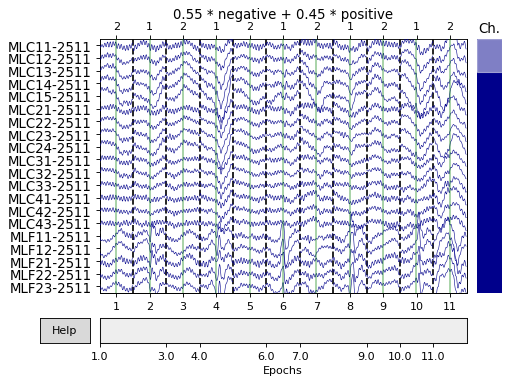

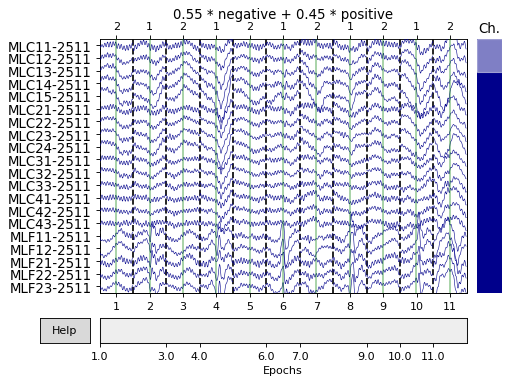

In [81]:
epochs.plot(picks=None, scalings=None, n_epochs=20, n_channels=20, title=None, events=None, event_colors=None, show=True, block=False, decim='auto')

In [82]:
epochs_array = []
epochs_data = epochs.get_data()
type(epochs.get_data())

numpy.ndarray

In [83]:
epochs_array = []
labels_array = []
ds_list = ['anonepi_02.ds', 'anonepi_03.ds', 'anonepi_04.ds', 'anonepi_05.ds', 'anonepi_06.ds', 'anonepi_08.ds', 'anonepi_09.ds']

for ds_file in ds_list:
    print('Start loading data...')
    print('From dataset: ' + ds_file)
    data, data_sti = load_data_events(ds_file)
    epochs, labels = compute_epochs_events(data_sti, data, ds_file.split('.')[0])
    epochs_data = epochs.get_data()
    epochs_array += epochs_data.tolist()
    labels_array += labels.tolist()

Start loading data...
From dataset: anonepi_02.ds
ds directory : /Users/mlion0200/GitRepo/bcni_epi/notebook/../data/anonepi_02.ds
    res4 data read.
    hc data read.
    Separate EEG position data file not present.
    Quaternion matching (desired vs. transformed):
       0.31   79.57   -0.00 mm <->    0.31   79.57    0.00 mm (orig :  -47.56   66.09 -265.98 mm) diff =    0.000 mm
      -0.31  -79.57   -0.00 mm <->   -0.31  -79.57    0.00 mm (orig :   56.93  -53.61 -274.89 mm) diff =    0.000 mm
     103.93   -0.00    0.00 mm <->  103.93   -0.00    0.00 mm (orig :   78.68   68.54 -232.42 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coordinate locations for 3 HPI coils added
Picked positions of 21 EEG channels from channel info
    21 EEG locations added to Polhemus data.
    Measurement info composed.
Finding samples for /Users/mlion0200/GitRepo/bcni_epi/notebook/../data/anonepi_02.ds/anonepi_02.meg4: 
    System

In [84]:
train_x_orig, test_x_orig, train_y_orig, test_y_orig = train_test_split(epochs_array, labels_array, test_size=0.2, random_state=0)

In [85]:
train_x_array = np.asarray(train_x_orig)
test_x_array = np.asarray(test_x_orig)
train_y_array = np.asarray(train_y_orig)
test_y_array = np.asarray(test_y_orig)
m_train = train_x_array.shape[0]
num_px = train_x_array.shape[1]
m_test = test_x_array.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("train_x_orig shape: " + str(train_x_array.shape))
print ("train_y shape: " + str(train_y_array.shape))
print ("test_x_orig shape: " + str(test_x_array.shape))
print ("test_y shape: " + str(test_y_array.shape))

Number of training examples: 76
Number of testing examples: 20
train_x_orig shape: (76, 151, 121)
train_y shape: (76,)
test_x_orig shape: (20, 151, 121)
test_y shape: (20,)


In [97]:
# Import from previous project - dnn
train_x = train_x_array.reshape(train_x_array.shape[0], train_x_array.shape[1], train_x_array.shape[2], 1)
test_x = test_x_array.reshape(test_x_array.shape[0], test_x_array.shape[1], test_x_array.shape[2], 1)
print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (76, 151, 121, 1)
test_x's shape: (20, 151, 121, 1)


In [20]:
#train_x = train_x.T
#test_x = test_x.T

In [46]:
#norm_train_x = normalize(train_x, norm='l2')
#norm_test_x = normalize(test_x, norm='l2')

ValueError: Found array with dim 4. the normalize function expected <= 2.

In [51]:
plt.plot(train_x[1,:])

IndexError: index 1 is out of bounds for axis 3 with size 1

In [87]:
train_y = train_y_array.reshape((1, train_y_array.shape[0]))
test_y = test_y_array.reshape((1, test_y_array.shape[0]))

In [88]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [91]:
Y_train_softmax = convert_to_one_hot(train_y, 3).T
Y_test_softmax = convert_to_one_hot(test_y, 3).T

In [101]:
def VGG16_model(X_train, X_test, Y_train, Y_test, input_shape):
    #(X_train_input, X_test_input) = img_resize(X_train, X_test, (151, 121))
    base_model = VGG16(weights=None, include_top=False, input_shape=input_shape)
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)
    
    X = base_model.output
    X = Flatten()(X)
    X = Dense(3, activation='softmax', kernel_initializer=glorot_uniform(seed=0))(X)

    # Create model
    model = Model(inputs=base_model.input, outputs=X, name='VGG16_model')
    
#     add_model = Sequential()
#     add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
#     add_model.add(Dense(256, activation='relu'))
#     add_model.add(Dense(1, activation='sigmoid'))

    #model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
    return model

In [102]:
vgg16_model = VGG16_model(train_x, test_x, Y_train_softmax, Y_test_softmax, (151, 121, 1))

In [73]:
plot_model(vgg16_model, to_file='vgg.png')

In [103]:
vgg16_model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
                  metrics=['accuracy'])
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 151, 121, 1)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 151, 121, 64)      640       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 151, 121, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 60, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 60, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 60, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 30, 128)       0         
__________

In [106]:
history = vgg16_model.fit(x=train_x, y=Y_train_softmax, validation_split=0.20, epochs=10, batch_size=64)

preds_vgg = vgg16_model.evaluate(x=test_x, y=Y_test_softmax)
print()
print("Loss = " + str(preds_vgg[0]))
print("Test Accuracy = " + str(preds_vgg[1]))

Train on 60 samples, validate on 16 samples
Epoch 1/10
60/60 [==============================] - 32s - loss: 1.0960 - acc: 0.6000 - val_loss: 1.0961 - val_acc: 0.4375
Epoch 2/10
60/60 [==============================] - 31s - loss: 1.0957 - acc: 0.6000 - val_loss: 1.0958 - val_acc: 0.4375
Epoch 3/10
60/60 [==============================] - 31s - loss: 1.0953 - acc: 0.6000 - val_loss: 1.0955 - val_acc: 0.4375
Epoch 4/10
60/60 [==============================] - 32s - loss: 1.0949 - acc: 0.6000 - val_loss: 1.0952 - val_acc: 0.4375
Epoch 5/10
60/60 [==============================] - 37s - loss: 1.0945 - acc: 0.6000 - val_loss: 1.0948 - val_acc: 0.4375
Epoch 6/10
60/60 [==============================] - 34s - loss: 1.0941 - acc: 0.6000 - val_loss: 1.0945 - val_acc: 0.4375
Epoch 7/10
60/60 [==============================] - 33s - loss: 1.0937 - acc: 0.6000 - val_loss: 1.0941 - val_acc: 0.4375
Epoch 8/10
60/60 [==============================] - 31s - loss: 1.0933 - acc: 0.6000 - val_loss: 1.093

In [59]:
model_vgg = VGG16(weights=None, include_top=False, input_shape=(151, 121, 1))
print(model_vgg.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 151, 121, 1)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 151, 121, 64)      640       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 151, 121, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 60, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 60, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 60, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 30, 128)       0         
__________